In [37]:
!pip install transformers torch transformer-lens datasets scikit-learn

KeyboardInterrupt: 

In [38]:
import json
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from transformer_lens import HookedTransformer
from transformers import GPT2Tokenizer
import warnings
import polars as pl
warnings.filterwarnings('ignore')

In [39]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [40]:
def load_jsonl_data(file_path):
    """Load data from JSONL file format"""
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            if line.strip():  # Skip empty lines
                data.append(json.loads(line.strip()))
    return data

data = load_jsonl_data('/content/sample_data/sample_data.jsonl')


In [41]:

df = pl.DataFrame(data)

In [42]:
print("Dataset loaded successfully!")
print(f"Total samples: {len(df)}")
print(f"Positive examples (privilege escalation): {df['label'].sum()}")
print(f"Negative examples (normal): {(~df['label']).sum()}")

Dataset loaded successfully!
Total samples: 2082
Positive examples (privilege escalation): 1082
Negative examples (normal): 1000


### Get a feeling for the data


In [43]:
print("\nCategory distribution:")
print(df['category'].value_counts())

print("\nObfuscation level distribution:")
print(df['obfuscation_level'].value_counts())

print("\nSample commands:")
for row in df.head().iter_rows():
    label_str = "PRIVILEGE ESCALATION" if row[1] else "NORMAL"
    print(f"[{label_str}] {row[0][:60]}{'...' if len(row[0]) > 60 else ''}")


Category distribution:
shape: (13, 2)
┌──────────────────┬───────┐
│ category         ┆ count │
│ ---              ┆ ---   │
│ str              ┆ u32   │
╞══════════════════╪═══════╡
│ suid_abuse       ┆ 166   │
│ false_positive   ┆ 125   │
│ kernel_exploit   ┆ 125   │
│ direct_pe        ┆ 166   │
│ normal_sudo      ┆ 250   │
│ …                ┆ …     │
│ permission_check ┆ 250   │
│ capability_abuse ┆ 125   │
│ legitimate_admin ┆ 250   │
│ service_abuse    ┆ 125   │
│ false_negative   ┆ 125   │
└──────────────────┴───────┘

Obfuscation level distribution:
shape: (3, 2)
┌───────────────────┬───────┐
│ obfuscation_level ┆ count │
│ ---               ┆ ---   │
│ i64               ┆ u32   │
╞═══════════════════╪═══════╡
│ 1                 ┆ 426   │
│ 2                 ┆ 218   │
│ 0                 ┆ 1438  │
└───────────────────┴───────┘

Sample commands:
[NORMAL] docker exec -it web-app bash
[NORMAL] tcpdump -i wlan0
[PRIVILEGE ESCALATION] echo '* * * * * root /tmp/backdoor.sh' >> /etc

In [44]:
df = df.with_columns(pl.col('label').cast(pl.Int64).alias('label_int'))

### Load model and extract activations

In [45]:
model = HookedTransformer.from_pretrained('gpt2', device=device)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

Loaded pretrained model gpt2 into HookedTransformer


In [46]:
tokenizer.pad_token = tokenizer.eos_token

In [47]:
print(f"Number of layers: {model.cfg.n_layers}")
print(f"Hidden dimension: {model.cfg.d_model}")

Number of layers: 12
Hidden dimension: 768


In [49]:
labels = df['label'].cast(pl.Int64).to_numpy()

In [50]:
def extract_activations(commands, layer_idx=-1, activation_type="resid_post"):

    if layer_idx == -1:
        layer_idx = model.cfg.n_layers - 1

    activations = []


    batch_size = 8

    for i in range(0, len(commands), batch_size):
        batch_commands = commands[i:i+batch_size]

        tokens = tokenizer(
            batch_commands,
            padding=True,
            truncation=True,
            max_length=128,  #good length for bash commands
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            _, cache = model.run_with_cache(tokens.input_ids)

            if layer_idx == -1:
                layer_idx = model.cfg.n_layers - 1

            layer_activations = cache[f"blocks.{layer_idx}.hook_{activation_type}"]


            pooled_activations = layer_activations.mean(dim=1)  # Shape: (batch_size, d_model)

            activations.append(pooled_activations.cpu().numpy())

    return np.vstack(activations)

In [51]:
print("\nExtracting activations from the last layer of GPT-2...")
all_commands = df['command'].to_list() # Convert Polars Series to Python list
command_activations = extract_activations(all_commands)

print(f"Shape of extracted activations: {command_activations.shape}")


Extracting activations from the last layer of GPT-2...
Shape of extracted activations: (2082, 768)


In [52]:
def extract_multiple_layers(commands, layers_to_try=None):
    """Extract activations from multiple layers for comparison"""
    if layers_to_try is None:
        # Try a few different layers
        layers_to_try = [0, model.cfg.n_layers // 2, model.cfg.n_layers - 1]

    all_activations = {}

    for layer in layers_to_try:
        print(f"Extracting activations from layer {layer}...")
        activations = extract_activations(commands, layer_idx=layer)
        all_activations[f"layer_{layer}"] = activations

    return all_activations

print(f"\nReady to extract activations from all {len(df)} commands...")


Ready to extract activations from all 2082 commands...


In [53]:
import re
from typing import Dict

def command_to_template(cmd: str) -> str:
    # remove paths, numbers, quoted strings, and collapse spaces
    cmd = re.sub(r"/[^\s]+", "/PATH", cmd)
    cmd = re.sub(r"-?\d+", "<NUM>", cmd)
    cmd = re.sub(r"\".*?\"|'.*?'", "<STR>", cmd)
    cmd = re.sub(r"\s+", " ", cmd).strip()
    return cmd

def train_and_evaluate_probe_no_leakage(activations, labels, commands, test_size=0.3, random_state=42):
    """
    Train linear probe on activations, ensuring no command template appears in both train and test.
    Returns test_df with original index.
    """
    df = pd.DataFrame({
        'command': commands,
        'label': labels,
        'activation': list(activations)
    })
    df['template'] = df['command'].apply(command_to_template)

    unique_templates = df['template'].unique()
    train_templates, test_templates = train_test_split(
        unique_templates,
        test_size=test_size,
        random_state=random_state,
        stratify=[df[df['template']==t]['label'].iloc[0] for t in unique_templates]
    )

    train_df = df[df['template'].isin(train_templates)].reset_index(drop=True)
    test_df = df[df['template'].isin(test_templates)].reset_index(drop=False)

    X_train = np.array(train_df['activation'].tolist())
    y_train = train_df['label'].values
    X_test = np.array(test_df['activation'].tolist())
    y_test = test_df['label'].values

    probe = LogisticRegression(max_iter=1000, random_state=random_state)
    probe.fit(X_train, y_train)

    y_pred_train = probe.predict(X_train)
    y_pred_test = probe.predict(X_test)
    y_proba_test = probe.predict_proba(X_test)[:, 1]

    results = {
        'probe': probe,
        'train_accuracy': accuracy_score(y_train, y_pred_train),
        'test_accuracy': accuracy_score(y_test, y_pred_test),
        'classification_report': classification_report(y_test, y_pred_test, output_dict=True),
        'confusion_matrix': confusion_matrix(y_test, y_pred_test),
        'true_labels': y_test,
        'predictions': y_pred_test,
        'probabilities': y_proba_test,
        'n_train': len(X_train),
        'n_test': len(X_test)
    }
    return results, train_df, test_df

def analyze_by_category(test_df, results):
    test_df = test_df.copy()
    test_df['predictions'] = results['predictions']
    test_df['probabilities'] = results['probabilities']
    test_df['correct'] = (test_df['label'] == test_df['predictions'])

    category_analysis = test_df.groupby('category').agg({
        'correct': 'mean',
        'label': 'count',
        'probabilities': 'mean'
    }).round(3)
    category_analysis.columns = ['Accuracy', 'Count', 'Avg_Probability']
    return category_analysis

def keyword_baseline(df):
    dangerous_keywords = ['sudo', 'doas', 'pkexec', 'su -', 'chmod +s',
                          'setuid', 'systemctl', 'service', 'crontab',
                          '/bin/bash', '/bin/sh']

    def simple_classifier(cmd):
        return int(any(kw in cmd.lower() for kw in dangerous_keywords))

    preds = df['command'].apply(simple_classifier).values
    return accuracy_score(df['label'].values, preds)

def plot_results(layer_results: Dict[str, Dict]) -> None:
    """Plot probe performance across layers"""
    layers = []
    train_accs = []
    test_accs = []

    for layer_name, results in layer_results.items():
        layer_num = int(layer_name.split('_')[1])
        layers.append(layer_num)
        train_accs.append(results['train_accuracy'])
        test_accs.append(results['test_accuracy'])

    plt.figure(figsize=(10, 6))
    plt.plot(layers, train_accs, 'o-', label='Train Accuracy', color='blue')
    plt.plot(layers, test_accs, 'o-', label='Test Accuracy', color='red')
    plt.xlabel('Layer')
    plt.ylabel('Accuracy')
    plt.title('Probe Performance Across GPT-2 Layers')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


Dataset overview:
Total samples: 2082
Positive samples: 1082
Negative samples: 1000
Categories: {'category': shape: (13,)
Series: 'category' [str]
[
	"kernel_exploit"
	"false_positive"
	"normal_sudo"
	"suid_abuse"
	"library_hijack"
	…
	"false_negative"
	"direct_pe"
	"capability_abuse"
	"legitimate_admin"
	"system_monitoring"
], 'count': shape: (13,)
Series: 'count' [u32]
[
	125
	125
	250
	166
	125
	…
	125
	166
	125
	250
	125
]}

Extracting activations from multiple layers...
Extracting activations from layer 0...
Extracting activations from layer 3...
Extracting activations from layer 6...
Extracting activations from layer 9...
Extracting activations from layer 11...

Training probes for each layer...

Analyzing layer_0...
  Train accuracy: 0.993
  Test accuracy: 0.939
  Train size: 1487, Test size: 595

Analyzing layer_3...
  Train accuracy: 1.000
  Test accuracy: 0.955
  Train size: 1487, Test size: 595

Analyzing layer_6...
  Train accuracy: 1.000
  Test accuracy: 0.948
  Train siz

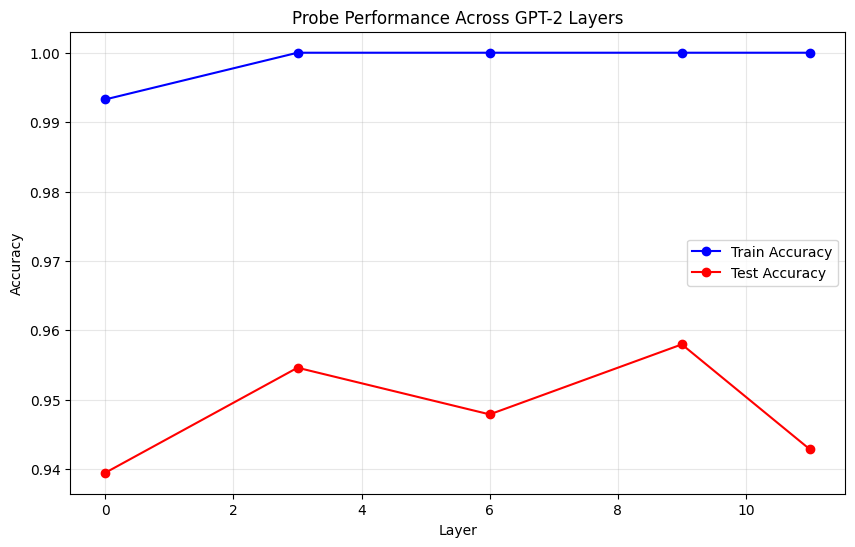


Error Analysis - Misclassified Examples:
Command: 'sudo -i'
  True label: True, Predicted: False, Category: direct_pe

Command: 'su - elasticsearch'
  True label: False, Predicted: True, Category: legitimate_admin

Command: 'su root'
  True label: True, Predicted: False, Category: direct_pe

Command: 'su - elasticsearch'
  True label: False, Predicted: True, Category: legitimate_admin

Command: 'su root'
  True label: True, Predicted: False, Category: direct_pe

Command: 'su - elasticsearch'
  True label: False, Predicted: True, Category: legitimate_admin

Command: 'sudo -i'
  True label: True, Predicted: False, Category: direct_pe

Command: 'bash -c 'sudo -i''
  True label: True, Predicted: False, Category: direct_pe

Command: 'su root'
  True label: True, Predicted: False, Category: direct_pe

Command: 'su root'
  True label: True, Predicted: False, Category: direct_pe


=== Additional Analysis for Report ===
ROC-AUC: 0.995
PR-AUC (Average Precision): 0.995

Per-layer F1 scores:
  l

In [57]:
def main():

    print(f"\nDataset overview:")
    print(f"Total samples: {len(df)}")
    print(f"Positive samples: {df['label'].sum()}")
    print(f"Negative samples: {(~df['label']).sum()}")
    print(f"Categories: {df['category'].value_counts().to_dict()}")

    all_commands = df['command'].to_list()
    labels = df['label'].to_numpy() # Use to_numpy() for Polars Series

    print(f"\nExtracting activations from multiple layers...")
    layers_to_analyze = [0, 3, 6, 9, 11]  # GPT-2 has 12 layers (0-11)
    all_layer_activations = extract_multiple_layers(all_commands, layers_to_analyze)

    layer_results = {}

    print(f"\nTraining probes for each layer...")
    for layer_name, activations in all_layer_activations.items():
        print(f"\nAnalyzing {layer_name}...")
        results, train_df, test_df = train_and_evaluate_probe_no_leakage(
            activations, labels, all_commands
        )

        layer_results[layer_name] = results

        print(f"  Train accuracy: {results['train_accuracy']:.3f}")
        print(f"  Test accuracy: {results['test_accuracy']:.3f}")
        print(f"  Train size: {results['n_train']}, Test size: {results['n_test']}")

    baseline_acc = keyword_baseline(pd.DataFrame({'command': all_commands, 'label': labels}))
    print(f"\nKeyword baseline accuracy: {baseline_acc:.3f}")

    #best performing layer
    best_layer = max(layer_results.keys(), key=lambda x: layer_results[x]['test_accuracy'])
    print(f"\nBest performing layer: {best_layer}")

    best_results = layer_results[best_layer]
    best_activations = all_layer_activations[best_layer]

    results, train_df, test_df = train_and_evaluate_probe_no_leakage(
        best_activations, labels, all_commands
    )

    df_with_categories = df.clone().with_row_index('index') #index to polars df
    test_df_with_cats = test_df.merge(
        df_with_categories[['index', 'category']].to_pandas(),
        on='index',
        how='left'
    ).drop(columns=['index'])


    print(f"\nCategory-wise analysis for {best_layer}:")
    # Ensure the lengths match before assigning
    if len(test_df_with_cats) == len(results['predictions']):
        category_results = analyze_by_category(test_df_with_cats, results)
        print(category_results)
    else:
        print("Error: Length mismatch between test_df_with_cats and results arrays.")
        print(f"Length of test_df_with_cats: {len(test_df_with_cats)}")
        print(f"Length of results['predictions']: {len(results['predictions'])}")

    print(f"\nConfusion Matrix for {best_layer}:")
    cm = results['confusion_matrix']
    print(f"True Negatives: {cm[0,0]}, False Positives: {cm[0,1]}")
    print(f"False Negatives: {cm[1,0]}, True Positives: {cm[1,1]}")


    print(f"\nClassification Report for {best_layer}:")
    report = results['classification_report']
    # Use 'True' as key for classification report for positive class
    print(f"Precision (Positive): {report['True']['precision']:.3f}")
    print(f"Recall (Positive): {report['True']['recall']:.3f}")
    print(f"F1-Score (Positive): {report['True']['f1-score']:.3f}")

    # Plot results
    plot_results(layer_results)


    print(f"\nError Analysis - Misclassified Examples:")
    test_df_with_cats['correct'] = (test_df_with_cats['label'] == results['predictions'])
    errors = test_df_with_cats[~test_df_with_cats['correct']].head(10)

    for _, row in errors.iterrows():
        print(f"Command: '{row['command']}'")
        print(f"  True label: {row['label']}, Predicted: {results['predictions'][_]}, Category: {row.get('category', 'Unknown')}")
        print()

    print("\n=== Additional Analysis for Report ===")

    best_layer_results = layer_results[best_layer]
    y_test = best_layer_results['true_labels']
    y_proba = best_layer_results['probabilities']
    y_pred = best_layer_results['predictions']
    # df_results is not directly available, we will recreate necessary parts from test_df_with_cats
    df_results = pd.DataFrame({
        'true': y_test,
        'pred': y_pred,
        'category': test_df_with_cats['category'] # Get categories from the merged df
    })


    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    print(f"ROC-AUC: {roc_auc:.3f}")
    print(f"PR-AUC (Average Precision): {pr_auc:.3f}")


    print("\nPer-layer F1 scores:")
    for layer, res in layer_results.items():
        f1 = f1_score(res['true_labels'], res['predictions'])
        print(f"  {layer}: {f1:.3f}")


    #missclassification
    misclassified = df_results[df_results["true"] != df_results["pred"]]
    mis_summary = misclassified["category"].value_counts()
    print("\nMisclassification counts by category:")
    print(mis_summary)


    avg_pos = y_proba[y_test == 1].mean()
    avg_neg = y_proba[y_test == 0].mean()
    print("\nCalibration check:")
    print(f"  Avg predicted probability (positives): {avg_pos:.3f}")
    print(f"  Avg predicted probability (negatives): {avg_neg:.3f}")

    # confusion matrix as df
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm,
                         index=["True Neg","True Pos"],
                         columns=["Pred Neg","Pred Pos"])
    print("\nConfusion Matrix (as table):")
    print(cm_df)


    return {
        'layer_results': layer_results,
        'best_layer': best_layer,
        'baseline_accuracy': baseline_acc,
        'category_analysis': category_results,
        'dataset': df,
        'additional_analysis': {
            'roc_auc': roc_auc,
            'pr_auc': pr_auc,
            'per_layer_f1': {layer: f1_score(res['true_labels'], res['predictions']) for layer, res in layer_results.items()},
            'misclassification_summary': mis_summary.to_dict(),
            'calibration_check': {'avg_pos_prob': avg_pos, 'avg_neg_prob': avg_neg},
            'confusion_matrix_df': cm_df.to_dict()
        }
    }

if __name__ == "__main__":
    results = main()

In [61]:
if 'results' in locals() and 'best_layer' in results and 'layer_results' in results:
    best_layer = results['best_layer']

    all_commands = results['dataset']['command'].to_list()
    labels = results['dataset']['label'].to_numpy()
    all_layer_activations = extract_multiple_layers(all_commands, [int(best_layer.split('_')[1])]) # Extract only for the best layer

    best_layer_activations = all_layer_activations[best_layer]



    temp_results, train_df_with_commands, test_df_with_commands = train_and_evaluate_probe_no_leakage(
        best_layer_activations, # Use activations of the best layer
        labels, # Use original labels
        all_commands # Use original commands
    )


    train_texts = train_df_with_commands['command'].to_list()
    test_texts = test_df_with_commands['command'].to_list()


    overlap = set(train_texts).intersection(set(test_texts))
    print(f"Number of overlapping samples: {len(overlap)}")
    if len(overlap) > 0:
        print("Examples of overlaps:", list(overlap)[:10])
else:
    print("Please run the main() function first to generate the results.")

Extracting activations from layer 9...
Number of overlapping samples: 0
